In [48]:
using Pkg
Pkg.activate("../data_generation")
import PowerModels as PM
import MathOptInterface as MOI
import JSON 
import Glob
using LinearAlgebra: cond
using Plots

const SOLVED_STATUSES = [MOI.OPTIMAL, MOI.LOCALLY_SOLVED, MOI.ALMOST_OPTIMAL, MOI.ALMOST_LOCALLY_SOLVED]
include("./utils.jl")
PM.silence()

  Activating project at `~/Documents/Projects/pfdelta_submitted/pfdelta/data_generation`


In [49]:
# Initialize arrays and parameters
results = Dict{Int64, Dict{Float64, Tuple{Float64, Bool, Float64}}}()
pv_curve_data = Dict{Int64, Dict{Float64, Dict}}()
raw_cpf_path = joinpath(@__DIR__, "..", "data", "case118", "n", "analysis", "raw_cpf") # TODO: may have to fix this later
sample_nums = [41]

1-element Vector{Int64}:
 41

In [50]:
for sample in sample_nums
    results[sample] = Dict{Float64, Tuple{Float64, Bool, Int64, Float64}}() 
    pv_curve_data[sample] = Dict{Float64, Dict}()
    get_condition_num_and_NR(results, raw_cpf_path, sample, pv_curve_data)
end

┌ Info: Processed 271 CPF files for sample 41
└ @ Main /Users/anarivera/Documents/Projects/pfdelta_submitted/pfdelta/notebooks/utils.jl:54


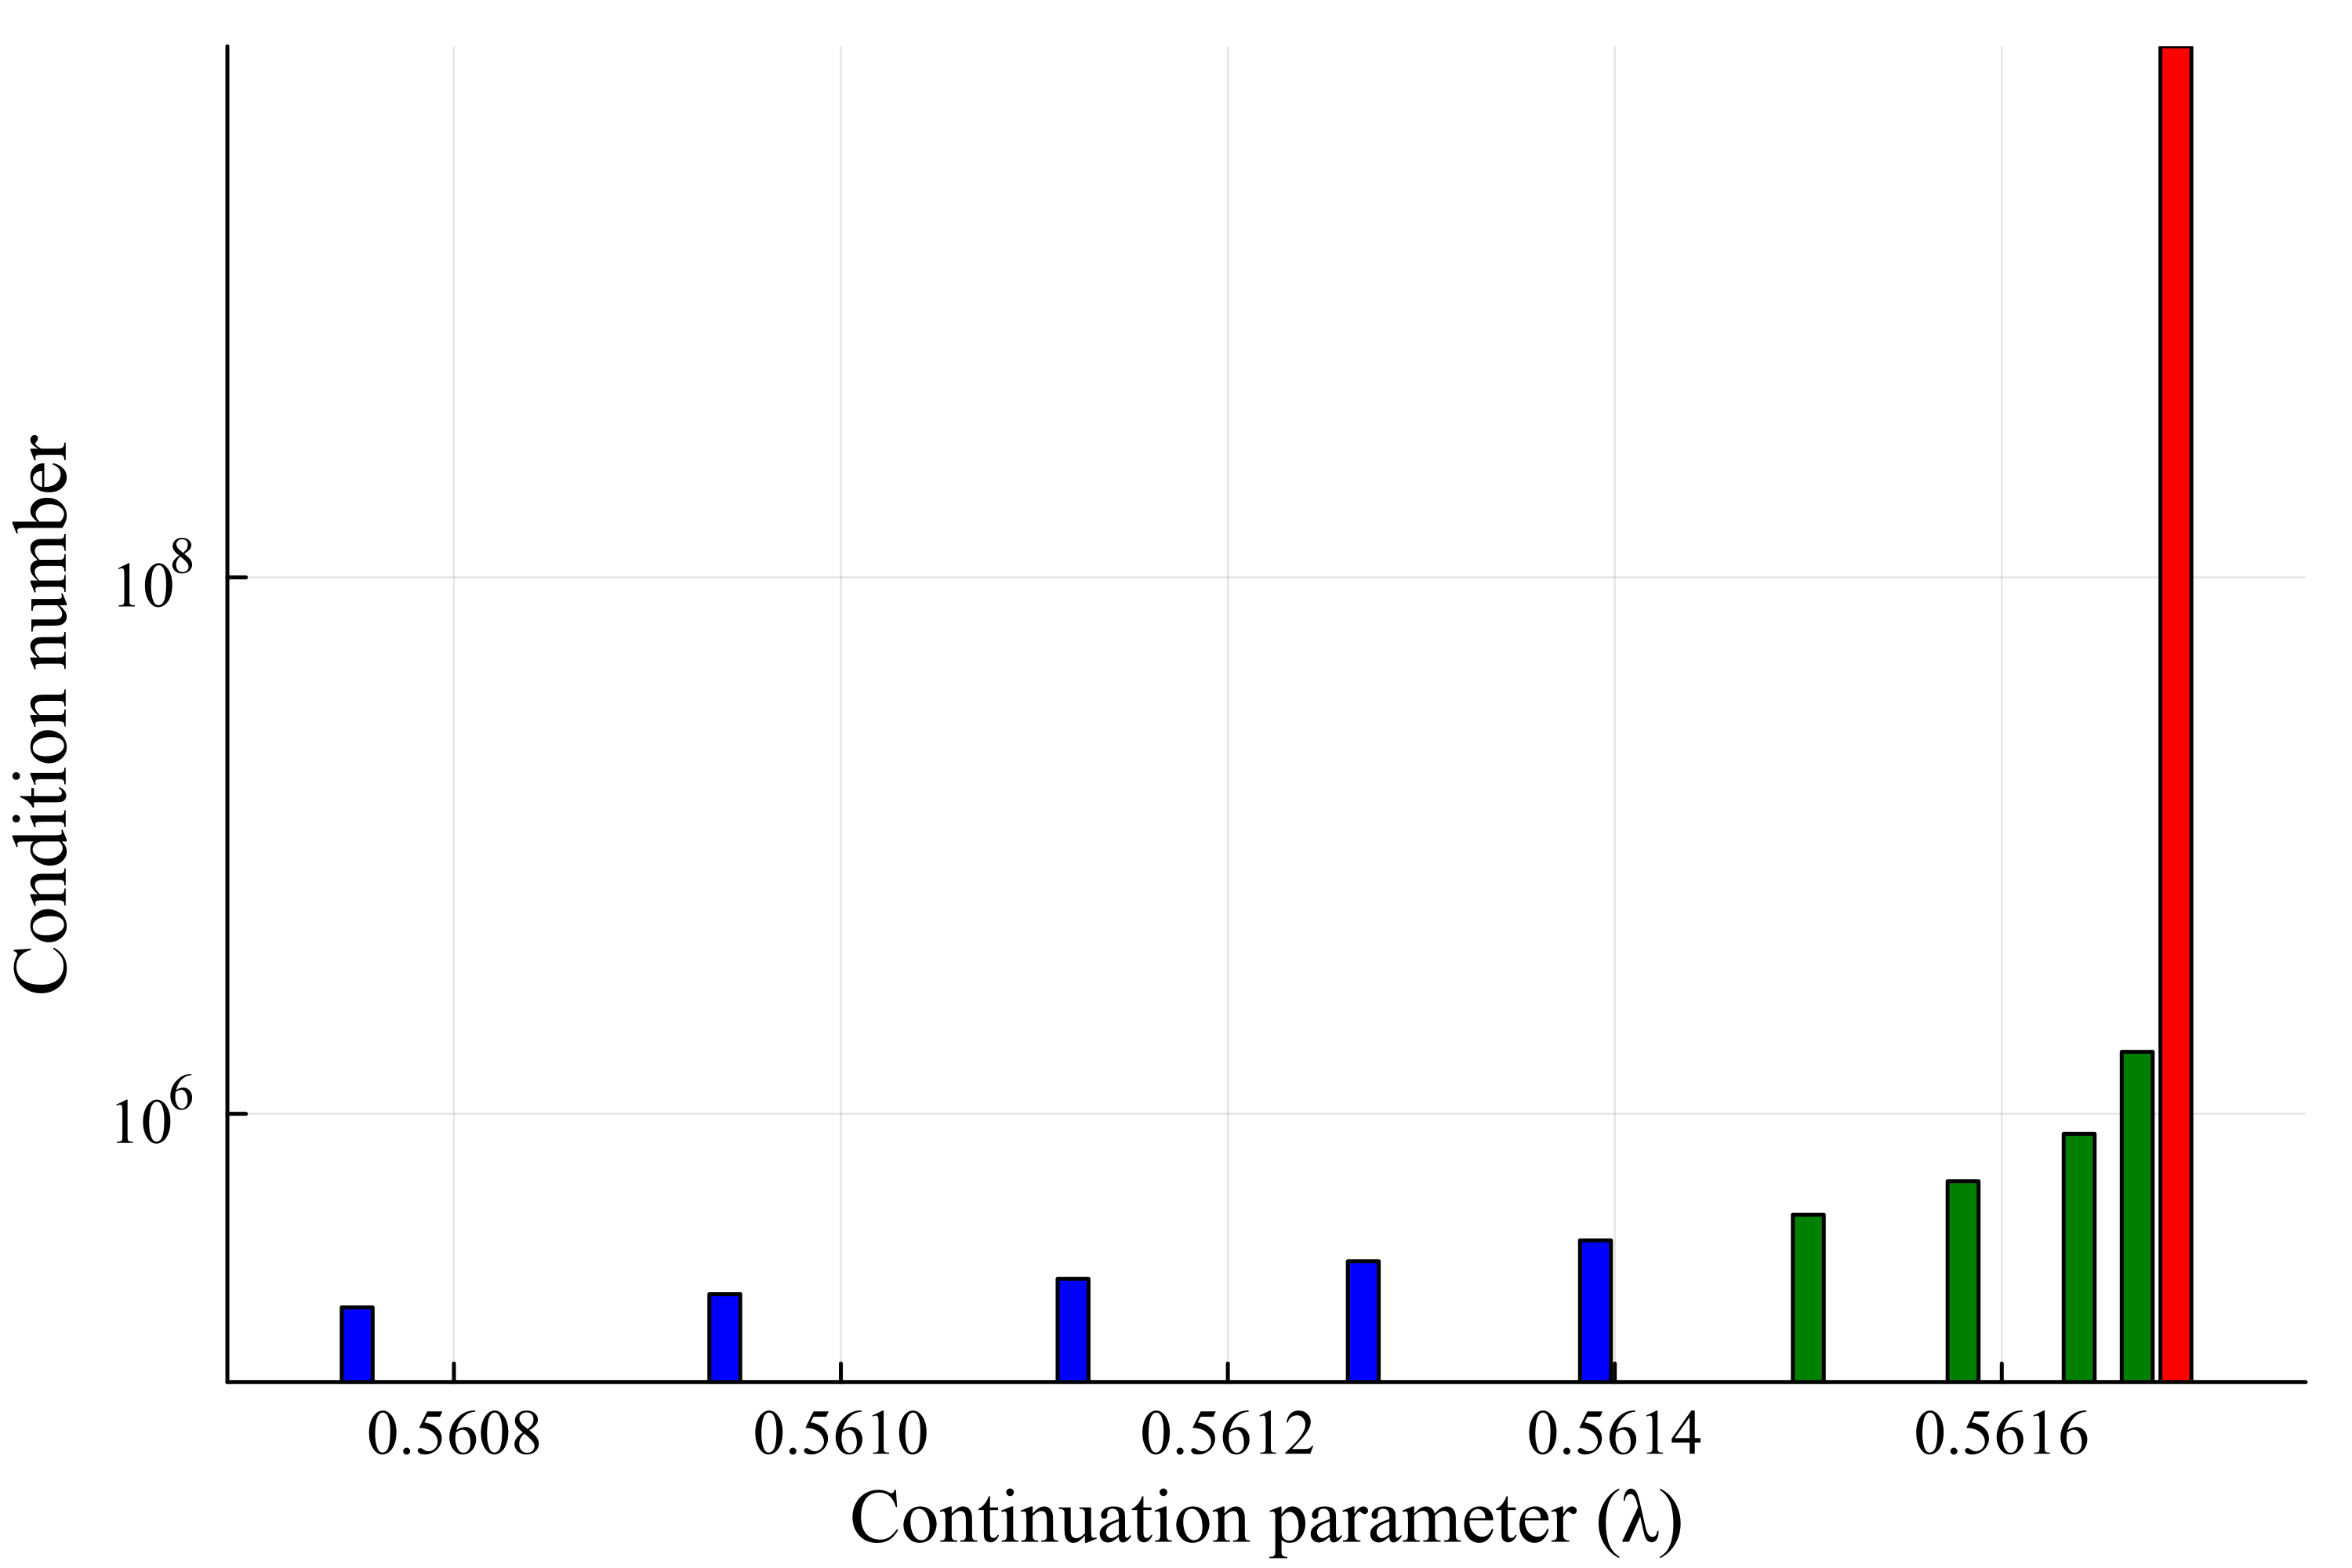

In [51]:
# Set global plot styles
output_dir_cond = "condition_number_plots"

default(
    fontfamily = "Times New Roman",
    guidefontsize = 12,
    titlefontsize = 16,
    tickfontsize = 10,
    legendfontsize = 12
)

for sample in sample_nums
    sample_results = results[sample]
    lams = sort(collect(keys(sample_results)))
    vals = [sample_results[lam] for lam in lams]

    cond_nums = first.(vals)
    convergence = getindex.(vals, 2)
    solve_time = last.(vals)

    # Extract last 6 values
    bar_lams = lams[end-9:end]
    bar_conds = cond_nums[end-9:end]

    # Color scheme: all blue, then update the last 5
    n = length(bar_lams)
    bar_colors = fill(:blue, n)
    if n >= 5
        bar_colors[end-4:end-1] .= :green
    end
    bar_colors[end] = :red

    # Bar plot
    p1 = bar(bar_lams, bar_conds,
            xlabel = "Continuation parameter (λ)",
            ylabel = "Condition number",
            legend = false,
            fillcolor = bar_colors,
            yscale = :log10,
            dpi = 500,
            )


    fig = plot(p1, size = (600, 400))
    display(fig)
    gui()
    savefig(fig, joinpath(output_dir_cond, "cond_num_sample$(sample).svg"))
end

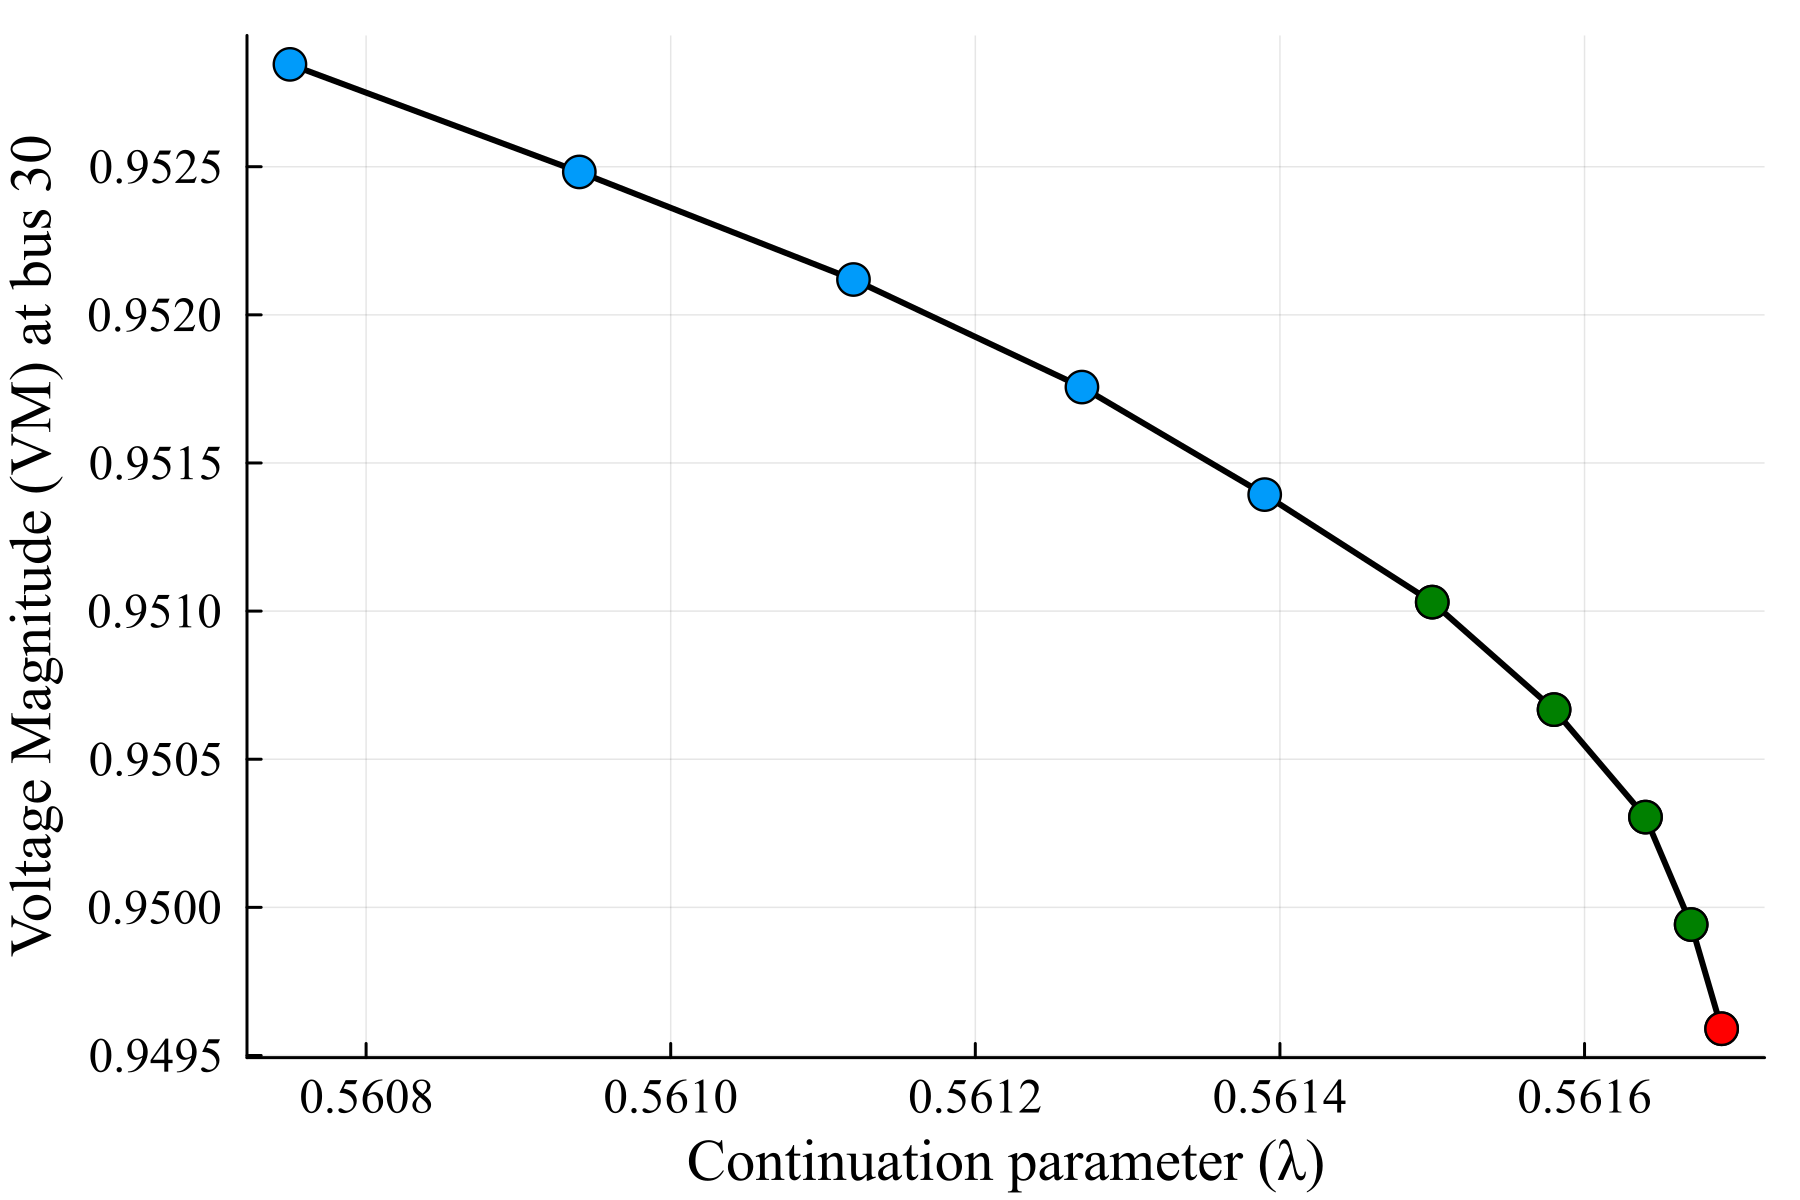

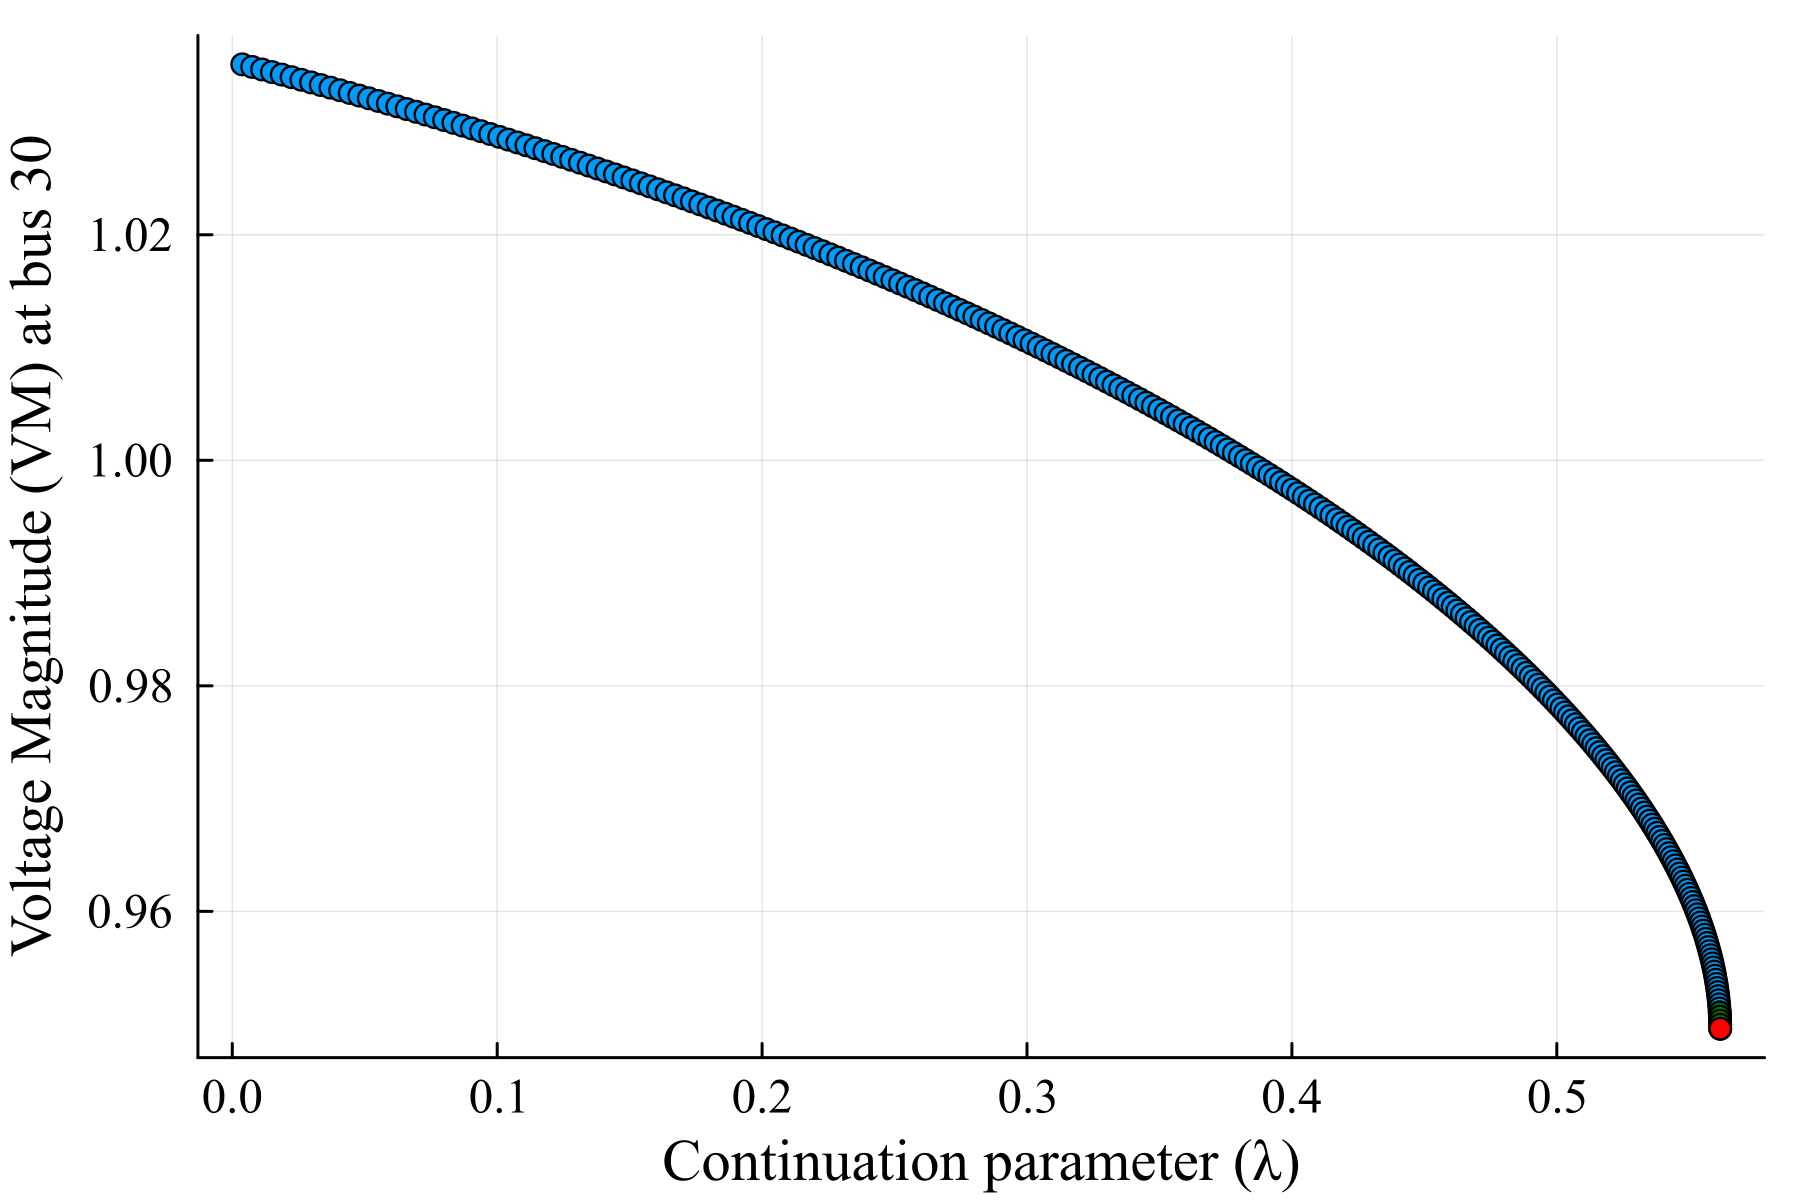

In [52]:
selected_bus = 30  # must be a PQ bus

# Set global plot styles
default(
    fontfamily = "Times New Roman",
    guidefontsize = 12,
    titlefontsize = 16,
    tickfontsize = 10,
    legendfontsize = 12
)
output_dir = "pv_curve_plots"

for sample in sample_nums
    lam_vm_pairs = Vector{Tuple{Float64, Float64}}()
    
    for (lam, net) in pv_curve_data[sample]
        vm = net["bus"][string(selected_bus)]["vm"]
        push!(lam_vm_pairs, (lam, vm))
    end

    # Sort by lambda
    sorted_pairs = sort(lam_vm_pairs, by = x -> x[1])
    lams = [x[1] for x in sorted_pairs]
    vms = [x[2] for x in sorted_pairs]

    n = length(lams)
    idx_last = n
    idx_green = max(n - 4, 1):(n - 1)
    idx_rest = 1:max(n - 5, 0)

    #### Plot p1: Only last 5 points with lines between them
    p1 = plot(lams[end-10+1:end], vms[end-10+1:end],
              label = "",
              xlabel = "Continuation parameter (λ)",
              ylabel = "Voltage Magnitude (VM) at bus $selected_bus",
              linecolor = :black,
              marker = :circle,
              legend = false,
                markersize = 6,
            linewidth = 2,
              dpi = 300,
              widen = true)

    # Color the last 4 in green
    scatter!(lams[idx_green], vms[idx_green],
             markercolor = :green,
             marker = :circle,
            markersize = 6,
             label = "")

    # Color the last point in red
    scatter!([lams[idx_last]], [vms[idx_last]],
             markercolor = :red,
             marker = :circle,
            markersize = 6,
             label = "")

    #### Plot p2: Full PV curve with highlighted last points
    p2 = plot(lams, vms,
              label = "",
              xlabel = "Continuation parameter (λ)",
              ylabel = "Voltage Magnitude (VM) at bus $selected_bus",
              linecolor = :black,
              marker = :circle,
              legend = false,
              dpi = 300)

    scatter!(lams[idx_green], vms[idx_green],
             markercolor = :green,
             marker = :circle,
             label = "")

    scatter!([lams[idx_last]], [vms[idx_last]],
             markercolor = :red,
             marker = :circle,

             label = "")

    display(p1)
    gui()
    display(p2)
    gui()
    savefig(p1, joinpath(output_dir, "pv_zoom_sample$(sample).svg"))
    savefig(p2, joinpath(output_dir, "pv_full_sample$(sample).svg"))
end